# Comparison zfp vs sz and model

In [9]:
import sys
sys.path.insert(0,'/p/home/jusers/donayreholtz1/hdfml/MyProjects/PROJECT_haf/users/donayreholtz1/lossy-ml/')

In [10]:
import numpy as np
import time
import xarray as xr
import subprocess
import os
import zfpy
import matplotlib.pyplot as plt
from lossycomp.compress import compress
from lossycomp.decompress import decompress
from lossycomp.plots import single_plot
from lossycomp.encodings import encode_lat, encode_lon

In [11]:
data_or = xr.open_mfdataset('/p/home/jusers/donayreholtz1/hdfml/MyProjects/PROJECT_haf/data/ECMWF/1980/*/temperature.nc', combine='by_coords')
data_or = data_or.sel(time=slice('1980-5-1T00:00:00','1980-5-20T23:00:00'),level = slice(978,1000))
data_or = data_or.transpose('time', 'latitude', 'longitude', 'level')
data_or = data_or['t']
data_or = data_or.values
data_or.shape

(480, 721, 1440, 1)

In [12]:
abs_error = 1

## Original Data

In [ ]:
data_r = np.expand_dims(data_or[:,:,:,0], axis=0)
#data_r = np.expand_dims(data_or, axis=0)
data_r = np.expand_dims(data_r, axis=4)
print(data_r.shape)
plt.rcParams.update({'font.size': 16})
single_plot(data_r, 0, "Original Data", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

## Model

In [ ]:
compressed_data = compress(data_or, abs_error, extra_channels = False, verbose = True, method='mask', mode = 'None', convs = 4, hyp = 'model_2')
decompressed_data = decompress(compressed_data, extra_channels = False, verbose = False, method='mask', mode = 'None', convs = 4, hyp = 'model_2')

{'name': '/FINAL_2/model_2', 'num_convs': 4, 'num_filters': 20, 'kernel_size': 5, 'lr': 0.0005898859206688481, 'res_blocks': 1, 'l2': 5.898859206688481e-05, 'extra': False, 'gaussian': False}
Load model...
Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 48, 48, 1)]   0         
_________________________________________________________________
Encoder (Functional)         (None, 1, 3, 3, 20)       224240    
_________________________________________________________________
Decoder (Functional)         (None, 16, 48, 48, 1)     224221    
Total params: 448,461
Trainable params: 448,461
Non-trainable params: 0
_________________________________________________________________
None
Standardizing data...
Chunking data...
Compressing data...
compressed.
Start decompressing


In [16]:
def psnr(y,x):
    vrange = np.max(y) - np.min(y)
    psnr = 20 * np.log10(vrange - (10 * np.log10(np.mean((y-x)*(y-x)))))
    return psnr


psnr1 = psnr(data_or[0,:,:,0], decompressed_data[0,:,:,0])
print('PSNR', psnr1)


print('Max error Model:', np.max(data_or[:,:,:,:]-decompressed_data[:,:,:,:]))
#np.testing.assert_allclose(data_or, decompressed_data, atol=abs_error, rtol=1e-4)

NameError: name 'decompressed_data' is not defined

In [ ]:
decom = np.expand_dims(decompressed_data, axis=0)
print(decom.shape)
single_plot(decom, 0, "Model", "Temperature (K)", data_r[0,0].min(), data_r[0,0].max())

## ZFP

In [27]:
compressed_data = zfpy.compress_numpy(data_or[:,:,:,0],  tolerance=1)
decompressed_array = zfpy.decompress_numpy(compressed_data)
print('CF: ', data_or[:,:,:,0].nbytes / len(compressed_data) )

CF:  13.59216702238398


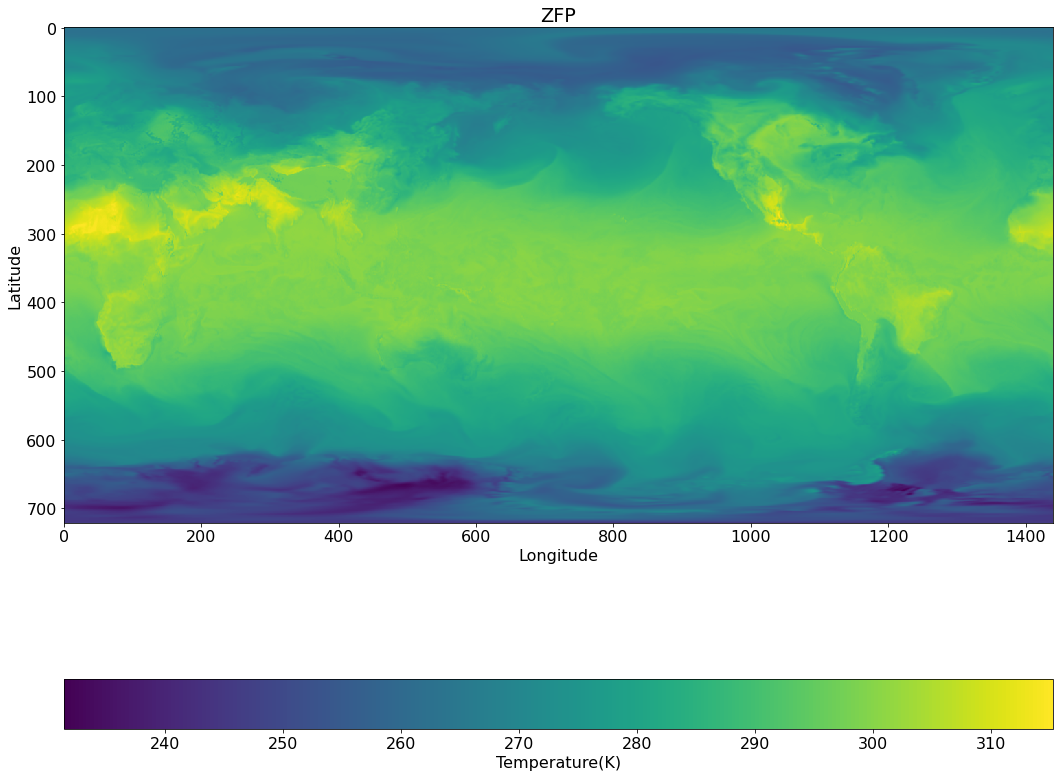

In [28]:
data_zfp = np.expand_dims(decompressed_array, axis=0)
data_zfp = np.expand_dims(data_zfp, axis=4)
single_plot(data_zfp, 0, "ZFP", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

In [29]:
psnr1 = psnr(data_or[0,:,:,0], decompressed_array[0,:,:])
print('PSNR', psnr1)

print('Max error ZFP:', np.max(data_or[:,:,:,0]-decompressed_array[:,:,:]))
#np.testing.assert_allclose(data_or[:,:,:,0], decompressed_array, atol=abs_error)

PSNR 41.09143113729882
Max error ZFP: 0.27215576



Data Original
Mean: 281.7313
Standard Dev.: 16.416666
Max Val: 319.23404
Min Val: 223.4798

Decompressed
Mean: 281.7294
Standard Dev.: 16.415968
Max Val: 319.2234
Min Val: 223.45996

Error
Mean: 0.0022636382
Standard Dev.: 0.03240522
Max error: 0.27215576
Min error: -0.2218628



Text(0, 0.5, 'Count')

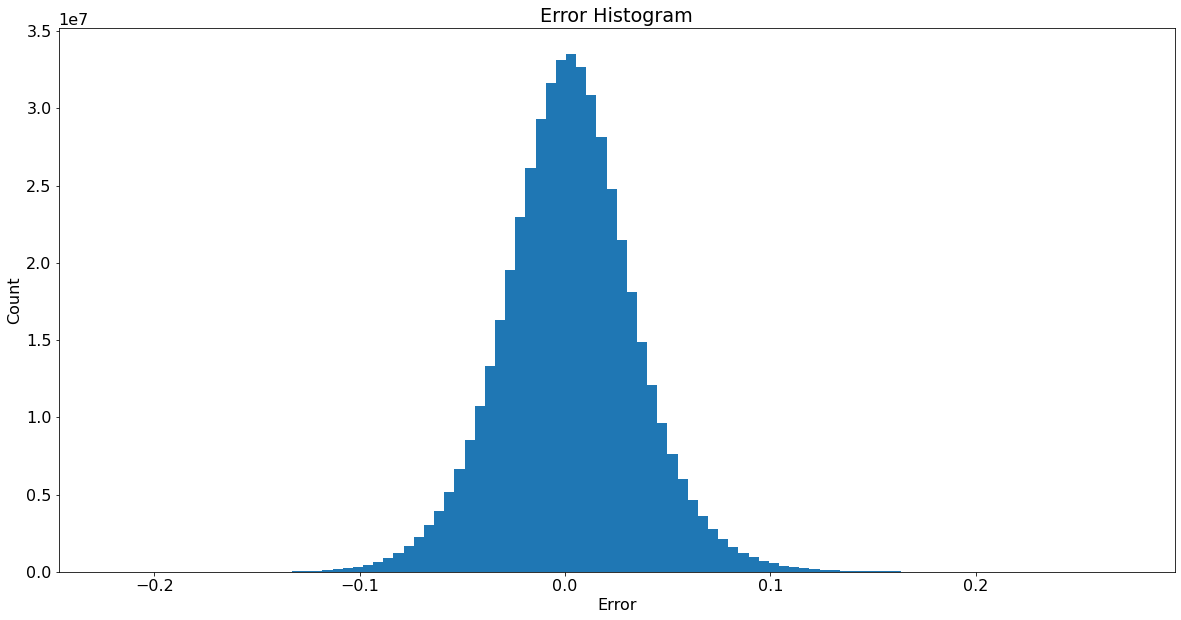

In [31]:
original = data_r
diff = (data_r[0,:,:,:,0]-decompressed_array)

print("")
print("Data Original")
print("=======")
print("Mean:", original.mean())
print("Standard Dev.:", original.std())
print("Max Val:", original.max())
print("Min Val:", original.min())
print("")
print("Decompressed")
print("=======")
print("Mean:", decompressed_array.mean())
print("Standard Dev.:", decompressed_array.std())
print("Max Val:", decompressed_array.max())
print("Min Val:", decompressed_array.min())
print("")
print("Error")
print("=======")
print("Mean:", diff.mean())
print("Standard Dev.:", diff.std())
print("Max error:", diff.max())
print("Min error:", diff.min())
print("")


plt.figure(figsize=(20,10))
plt.hist(diff.flatten(),100)
plt.title('Error Histogram')
plt.xlabel('Error')
plt.ylabel('Count')

## SZ

In [22]:
filename = 'zexact.dat'
data_or[:,:,:,0].tofile(filename)

subprocess.run(['../../SZ/build/bin/sz', '-z', '-f','-M', 'ABS', '-A', str(1),'-i',  filename, '-3', '480','721' ,'1440'], 
               stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)


subprocess.run(['../../SZ/build/bin/sz', '-x', '-f', '-s', filename + '.sz', '-3',  '480', '721' ,'1440'],
               stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)

z_sz = np.fromfile(filename + '.sz.out', dtype= np.float32)
z_sz = z_sz.reshape(data_or[:,:,:,0].shape)


print('SZ',  data_or[:,:,:,0].nbytes/os.path.getsize(filename + '.sz'))


# Cleanup
os.remove(filename)
os.remove(filename + '.sz')
os.remove(filename + '.sz.out')



SZ 27.053709916032588


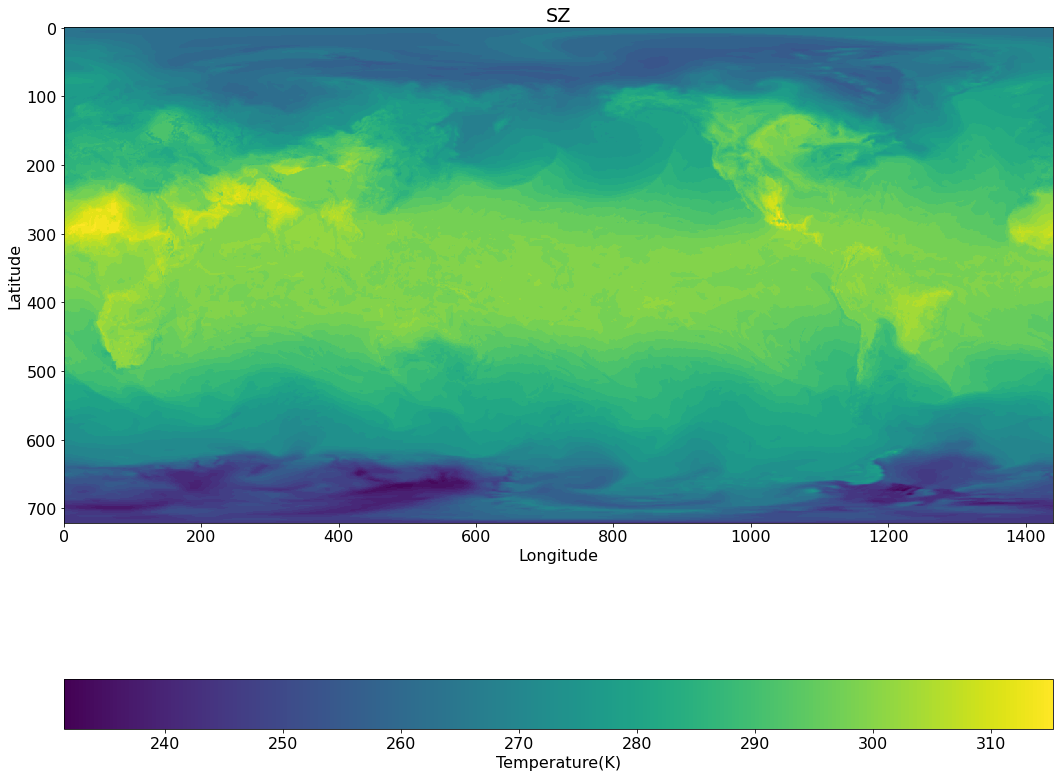

In [23]:
data_sz = np.expand_dims(z_sz, axis=0)
data_sz = np.expand_dims(data_sz, axis=4)
single_plot(data_sz, 0, "SZ", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

In [24]:
psnr1 = psnr(data_or[0,:,:,0], z_sz[0,:,:])
print('PSNR', psnr1)

print('Max error SZ:', np.max(data_or[:,:,:,0]-z_sz))

PSNR 38.94033880604922
Max error SZ: 1.0



Data Original
Mean: 281.7313
Standard Dev.: 16.416666
Max Val: 319.23404
Min Val: 223.4798

Decompressed
Mean: 281.7312
Standard Dev.: 16.426437
Max Val: 320.1352
Min Val: 222.913

Error
Mean: -0.0004457153
Standard Dev.: 0.576571
Max error: 1.0
Min error: -1.0



Text(0, 0.5, 'Count')

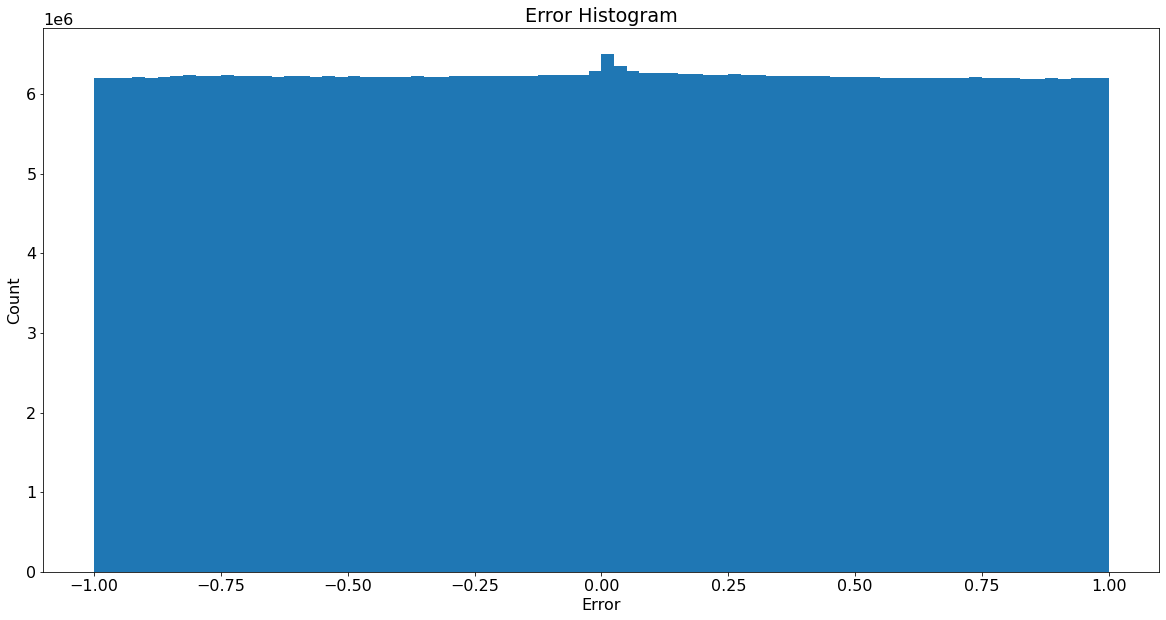

In [25]:
original = data_r
diff = (data_r[0,:,:,:,0]-z_sz)

print("")
print("Data Original")
print("=======")
print("Mean:", original.mean())
print("Standard Dev.:", original.std())
print("Max Val:", original.max())
print("Min Val:", original.min())
print("")
print("Decompressed")
print("=======")
print("Mean:", z_sz.mean())
print("Standard Dev.:", z_sz.std())
print("Max Val:", z_sz.max())
print("Min Val:", z_sz.min())
print("")
print("Error")
print("=======")
print("Mean:", diff.mean())
print("Standard Dev.:", diff.std())
print("Max error:", diff.max())
print("Min error:", diff.min())
print("")


plt.figure(figsize=(20,10))
plt.hist(diff.flatten(),80)
plt.title('Error Histogram')
plt.xlabel('Error')
plt.ylabel('Count')